## CNN

Источники:

https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/

https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data

https://github.com/MicrosoftDocs/ml-basics/blob/master/05b%20-%20Convolutional%20Neural%20Networks%20(PyTorch).ipynb

Оригинальный датасет: https://www.kaggle.com/datasets/likhon148/animal-data

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
import torch

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

In [ ]:
from tqdm import tqdm

In [ ]:
import torch.nn.functional as F

Загрузим данные. Нам необходимо, чтобы картинки были одинакового размера, поэтому при загрузке применим к ним преобразование, которое будет превращать исходные картинки в изображения размером 128*128 пикселей.

In [ ]:
transform = transforms.Compose([transforms.Resize(128),
                                 transforms.ToTensor()])

In [ ]:
dataset_animals = datasets.ImageFolder('/content/drive/MyDrive/ML_training_data/animals', transform=transform)

In [ ]:
dataset_animals.class_to_idx

{'Cat': 0, 'Lion': 1, 'Tiger': 2}

In [ ]:
len(dataset_animals)

383

Разделим картинки на тренировочные и тестовые:

In [ ]:
#train_set, val_set = torch.utils.data.random_split(dataset_animals, [300, 83])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_idx, validation_idx = train_test_split(np.arange(len(dataset_animals)),
                                             test_size=83,
                                             random_state=0,
                                             shuffle=True,
                                             stratify=dataset_animals.targets)

train_dataset = torch.utils.data.Subset(dataset_animals, train_idx)
validation_dataset = torch.utils.data.Subset(dataset_animals, validation_idx)

Мы будем работать с даталоадерами - объектами, позволяющими итерироваться по тренировочным и тестовым сабсетам, которые удобно подавать в модель:

In [ ]:
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)

Во время прохода по даталоадеру каждую итерацию мы будем получать минибатч фиксированной длины batch_size. Минибатч состоит из некоторого количества картинок и их лейблов. Возьмем для примера один минибатч и посмотрим на него:

In [ ]:
images, labels = next(iter(dataloader_train))

In [ ]:
# лейблы картинок в минибатче
labels

tensor([1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2, 1,
        0, 1, 1, 0, 1, 1, 2, 2])

In [ ]:
len(labels)

32

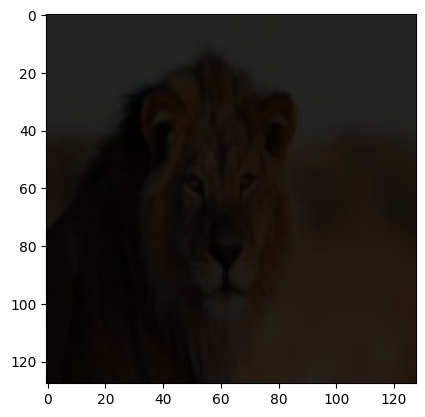

In [ ]:
# одна из картинок минибатча (всего их число равно batch_size)
fig, ax = plt.subplots()
image = images[3].numpy().transpose((1, 2, 0))
ax.imshow(image)

In [ ]:
# в картинке размером 128х128 пикселей три цветовых канала
images[3].shape

torch.Size([3, 128, 128])

### Нейросеть

Мы создадим обычную сверточную нейросеть для классификации изображений с двумя сверточными слоями. Применим один раз дропаут и один раз пулинг.

In [ ]:
class ImageCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.drop = nn.Dropout2d(p=0.2)

        # Для создания выходного слоя нам нужно заранее знать размерность, которую выдает последний скрытый слой.
        # Перед выходным слоем мы сделаем выдачу последней свертки плоской (см. ниже)
        # Поскольку мы один раз применяем pooling=2, измерения наших картинкок уменьшатся с 128 до 64
        # Число же выходных каналов последней свертки равно 24
        # В результате нам нужно получить 3 колонки вероятностей по числу категорий
        self.fc = nn.Linear(in_features=64 * 64 * 24, out_features=3)

    def forward(self, x):

        # первая свертка
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool(x)

        # вторая свертка
        x = self.conv2(x)
        x = self.act2(x)
        x = self.drop(x)

        # превращение последеней свертки в плоский тензор
        x_viewed = x.view(-1, 64 * 64 * 24)

        x = self.fc(x_viewed)

        return x

### По шагам:

Давайте посмотрим, что происходит с данными, поданными в модель, по шагам. Помните, что это только forward pass: обратный проход будет потом, во время тренировки.

Сначала убедимся, что класс модели написан правильно. Сделаем объект модели подобно тому, как делали объекты моделей в sklearn:

In [ ]:
model = ImageCNN().to(device)

Выполним forward pass модели. Так как мы ее еще не обучали, веса в ней инициализированы случайно, поэтому хороших предсказаний не будет.

In [ ]:
probs = model(images.to(device))

Получаем вектор размерностью (размер минибатча*количество классов):

In [ ]:
probs.size()

torch.Size([32, 3])

То, что мы получили, называется **логитами** - финальными предсказаниями модели, еще не прошедшими через последнюю функцию активации. Мы не используем активацию на последнем слое, т.к. хотим применить CrossEntropyLoss, который содержит софтмакс-активацию внутри себя.

In [ ]:
# посмотрим на вероятности каждого класса
probs[:10]

tensor([[ 0.0784, -0.0274,  0.0641],
        [ 0.0848,  0.0249, -0.0358],
        [ 0.0587, -0.0487, -0.0179],
        [ 0.0150,  0.0482,  0.0077],
        [ 0.0942, -0.0073, -0.0008],
        [ 0.0118,  0.0118, -0.0074],
        [ 0.0164,  0.0642, -0.0118],
        [ 0.0436,  0.0008, -0.0035],
        [ 0.0920, -0.0892, -0.0200],
        [-0.0132,  0.0611,  0.0577]], grad_fn=<SliceBackward0>)

Наша первая свертка принимает входное изображение, состоящее из трех каналов input_channels, и преобразовывает его в 12 каналов (out_channels). Ядро свертки имеет размерность 3 (kernel_size), шаг 1 и паддинг 1.

In [ ]:
conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1).to(device)

Пулинг-слой будет снижать размерность свертки в два раза.

In [ ]:
pool = nn.MaxPool2d(kernel_size=2).to(device)

Следующая свертка принимает результаты предыдущей, поэтому в ней 12 входных каналов. Она переведет их в 24:

In [ ]:
conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1).to(device)

Дропаут регуляризует нашу нейросеть:

In [ ]:
drop = nn.Dropout2d(p=0.2).to(device)

Возьмем наш минибатч картинок и посмотрим, как они изменятся в процессе forward pass'a нейросети:

In [ ]:
x = images.to(device)

In [ ]:
x.size()

torch.Size([32, 3, 128, 128])

In [ ]:
x = conv1(x)

In [ ]:
x.size()

torch.Size([32, 12, 128, 128])

In [ ]:
x = pool(x)

In [ ]:
x.size()

torch.Size([32, 12, 64, 64])

In [ ]:
x = conv2(x)

In [ ]:
x.size()

torch.Size([32, 24, 64, 64])

Итак, у нас есть четырехмерный выход сверточных слоев. Но для того, чтобы получить вероятности классов, нам нужна двумерная матрица. Поэтому мы сначала при помощи метода .view() уменьшим размерность, а затем при помощи полносвязного слоя достанем логиты:

In [ ]:
x = x.view(-1, 64 * 64 * 24)

In [ ]:
x.size()

torch.Size([32, 98304])

In [ ]:
fc = nn.Linear(in_features=64 * 64 * 24, out_features=3).to(device)

In [ ]:
x = fc(x)

In [ ]:
x.size()

torch.Size([32, 3])

### Обучение

Нередко в нейросетях считают accuracy, а не f1-score, когда оценивают качество на каждой эпохе. В этот раз мы тоже так сделаем.

In [ ]:
from sklearn.metrics import accuracy_score

Определим функцию потерь и метод оптимизации:

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Мы будем тренироваться 25 эпох.

In [ ]:
n_epochs = 25

for epoch in tqdm(range(n_epochs)):

    epoch_loss = []

    for inputs, labels in dataloader_train:

        optimizer.zero_grad()

        y_pred = model(inputs.to(device))
        loss = loss_fn(y_pred.to(device), labels.to(device))

        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    acc_scores = []

    # будем сразу на каждой эпохе делать предсказания на тестовом сете и смотреть на качество
    for inputs, labels in dataloader_val:
        y_pred_probs = model(inputs.to(device))
        current_y_pred = torch.argmax(y_pred_probs, 1)
        acc_scores.append(accuracy_score(labels.cpu(), current_y_pred.cpu()))

    avg_acc = np.mean(acc_scores)

    print('Epoch {0}, loss {1}, accuracy {2}'.format(epoch, sum(epoch_loss)/len(epoch_loss), avg_acc))
    epoch_loss = []

  4%|▍         | 1/25 [01:36<38:44, 96.84s/it]

Epoch 0, loss 1.2932582259178163, accuracy 0.46326754385964913


  8%|▊         | 2/25 [01:41<16:13, 42.33s/it]

Epoch 1, loss 1.043209546804428, accuracy 0.5614035087719298


 12%|█▏        | 3/25 [01:46<09:16, 25.30s/it]

Epoch 2, loss 0.9481885433197021, accuracy 0.44188596491228066


 16%|█▌        | 4/25 [01:50<05:55, 16.92s/it]

Epoch 3, loss 0.8947381675243378, accuracy 0.4775219298245614


 20%|██        | 5/25 [01:54<04:08, 12.44s/it]

Epoch 4, loss 0.8679572880268097, accuracy 0.6030701754385964


 24%|██▍       | 6/25 [01:59<03:07,  9.88s/it]

Epoch 5, loss 0.7783774971961975, accuracy 0.5120614035087719


 28%|██▊       | 7/25 [02:04<02:27,  8.19s/it]

Epoch 6, loss 0.6793279945850372, accuracy 0.6414473684210527


 32%|███▏      | 8/25 [02:08<01:57,  6.92s/it]

Epoch 7, loss 0.638408237695694, accuracy 0.6902412280701755


 36%|███▌      | 9/25 [02:13<01:40,  6.25s/it]

Epoch 8, loss 0.5514878481626511, accuracy 0.7182017543859649


 40%|████      | 10/25 [02:17<01:26,  5.76s/it]

Epoch 9, loss 0.5455532968044281, accuracy 0.6447368421052632


 44%|████▍     | 11/25 [02:22<01:15,  5.39s/it]

Epoch 10, loss 0.4630326837301254, accuracy 0.7039473684210527


 48%|████▊     | 12/25 [02:27<01:09,  5.37s/it]

Epoch 11, loss 0.45930623114109037, accuracy 0.668859649122807


 52%|█████▏    | 13/25 [02:32<01:01,  5.10s/it]

Epoch 12, loss 0.4155220717191696, accuracy 0.7911184210526315


 56%|█████▌    | 14/25 [02:36<00:53,  4.90s/it]

Epoch 13, loss 0.4068168491125107, accuracy 0.7351973684210527


 60%|██████    | 15/25 [02:41<00:49,  4.99s/it]

Epoch 14, loss 0.3689123898744583, accuracy 0.6518640350877193


 64%|██████▍   | 16/25 [02:46<00:44,  4.93s/it]

Epoch 15, loss 0.3874125242233276, accuracy 0.7664473684210527


 68%|██████▊   | 17/25 [02:51<00:38,  4.76s/it]

Epoch 16, loss 0.33187568336725237, accuracy 0.7768640350877193


 72%|███████▏  | 18/25 [02:55<00:32,  4.70s/it]

Epoch 17, loss 0.34261559695005417, accuracy 0.7702850877192983


 76%|███████▌  | 19/25 [03:00<00:28,  4.69s/it]

Epoch 18, loss 0.30201790295541286, accuracy 0.7768640350877193


 80%|████████  | 20/25 [03:04<00:22,  4.49s/it]

Epoch 19, loss 0.27236354202032087, accuracy 0.7976973684210527


 84%|████████▍ | 21/25 [03:08<00:17,  4.37s/it]

Epoch 20, loss 0.2651439800858498, accuracy 0.8536184210526315


 88%|████████▊ | 22/25 [03:13<00:14,  4.72s/it]

Epoch 21, loss 0.23595127016305922, accuracy 0.7664473684210527


 92%|█████████▏| 23/25 [03:18<00:09,  4.68s/it]

Epoch 22, loss 0.23560726791620254, accuracy 0.787280701754386


 96%|█████████▌| 24/25 [03:22<00:04,  4.58s/it]

Epoch 23, loss 0.2224020928144455, accuracy 0.7944078947368421


100%|██████████| 25/25 [03:28<00:00,  8.32s/it]

Epoch 24, loss 0.21123702824115753, accuracy 0.8640350877192983


## RNN

Продолжаем изучать классификацию имен по [этому](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) туториалу.

Предобработку берем с прошлого раза.

In [ ]:
import os
from collections import defaultdict

In [ ]:
from tqdm import tqdm

In [ ]:
import random

In [ ]:
import torch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
category_lines = defaultdict(list)

for filename in os.listdir('/content/drive/MyDrive/ML_training_data/names'):
  category_name = filename[:-4]
  with open(os.path.join('/content/drive/MyDrive/ML_training_data/names', filename), 'r') as f:
    lines = f.read().strip().split('\n')
    category_lines[category_name] = lines

In [ ]:
category_lines.keys()

dict_keys(['Chinese', 'Arabic', 'Czech', 'German', 'Korean', 'Japanese', 'Dutch', 'Polish', 'French', 'Greek', 'Portuguese', 'Scottish', 'Irish', 'Spanish', 'English', 'Italian', 'Vietnamese', 'Russian'])

In [ ]:
print(category_lines['Czech'][105:115])

['Grabski', 'Grozmanova', 'Grulich', 'Grygarova', 'Hadash', 'Hafernik', 'Hajek', 'Hajicek', 'Hajkova', 'Hana']


In [ ]:
unique_letters = set()

for k, v in category_lines.items():
  for word in v:
    unique_letters.update(set(word))

In [ ]:
all_letters_list = list(unique_letters)
all_letters = ''.join(all_letters_list)
n_letters = len(all_letters)

In [ ]:
n_letters += 1

In [ ]:
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cpu


В этот раз закодируем имена по-другому: каждому имени поставим в соответствие вектор размерности (количество букв\*1\*количество уникальных символов). Единица посередине нужна, чтобы притвориться, что каждый вектор является минибатчем размерностью 1 (технический момент для пайторча). Каждый раз, когда мы создаем какой-нибудь тензор, мы сначала создаем тензор из нулей при помощи функции torch.zeros(), а потом заполняем его числами.

In [ ]:
def letterToIndex(letter):
    # преобразование буквы в индекс
    return all_letters.find(letter)


def letterToTensor(letter):
    # преобразование буквы в тензор
    tensor = torch.zeros(1, n_letters)
    if letter in all_letters:
      tensor[0][letterToIndex(letter)] = 1
    else:
      tensor[0][-1] = 1
    return tensor


def lineToTensor(line):
    # преобразование имени в тензор
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor.to(device)


print(letterToTensor('9'))
print(lineToTensor('Zahar'))
print(lineToTensor('Zahar').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 

### Нейросеть

Мы инициализируем рекуррентную нейросеть как обычную с одним входным слоем, двумя скрытыми и одним выходным. Мы будем делать forward pass по входному и скрытому слою, затем суммировать их веса и применять к ним функцию активации, получая скрытые состояния. Их мы затем передадим в выходной слой и примерим софтмакс, т.к. у нас по-прежнему многоклассовая классификация.

In [110]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.init_to_hidden = nn.Linear(input_size, hidden_size)
        self.hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
        self.hidden_to_output = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.init_to_hidden(input) + self.hidden_to_hidden(hidden))
        output = self.hidden_to_output(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # поскольку нам нужно чем-то заполнить скрытый слой при самом первом проходе, мы инициализируем его нулями
        return torch.zeros(1, self.hidden_size)

### По шагам

Сначала инициализируем объект модели и посмотрим, что она работает.

In [111]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories).to(device)

Наша рекуррентная нейросеть будет идти по каждой букве слова, сохраняя информацию о предыдущих буквах, чтобы затем сделать предсказание категории, когда буквы закончатся. Давайте попробуем пройтись только по одной букве:

In [112]:
input = lineToTensor('Zahar')
# перед предсказанием каждого слова нам нужно не только превратить слово в тензор, но и инициализировать скрытый слой:
hidden = rnn.initHidden()

output, next_hidden = rnn(input[0].to(device), hidden.to(device))
print(output)

tensor([[-2.8443, -2.9629, -2.9125, -2.9273, -2.9064, -2.9725, -3.0511, -2.8518,
         -2.8318, -2.9245, -2.6988, -2.9165, -2.8645, -2.9750, -2.9267, -2.7487,
         -2.9029, -2.8672]], grad_fn=<LogSoftmaxBackward0>)


Теперь мы получили уже не логиты, а полноценные предсказания, так как внутри модели есть финальная функция активации - LogSoftmax. Но мы пока что не обучались, так что предсказания не очень хороши.

Если ориентироваться на эту картинку из презентации (Bao et al., 10.1371/journal.pone.0180944), выход output соответствует Ot-1, а скрытое состояние next_hidden - St-1:

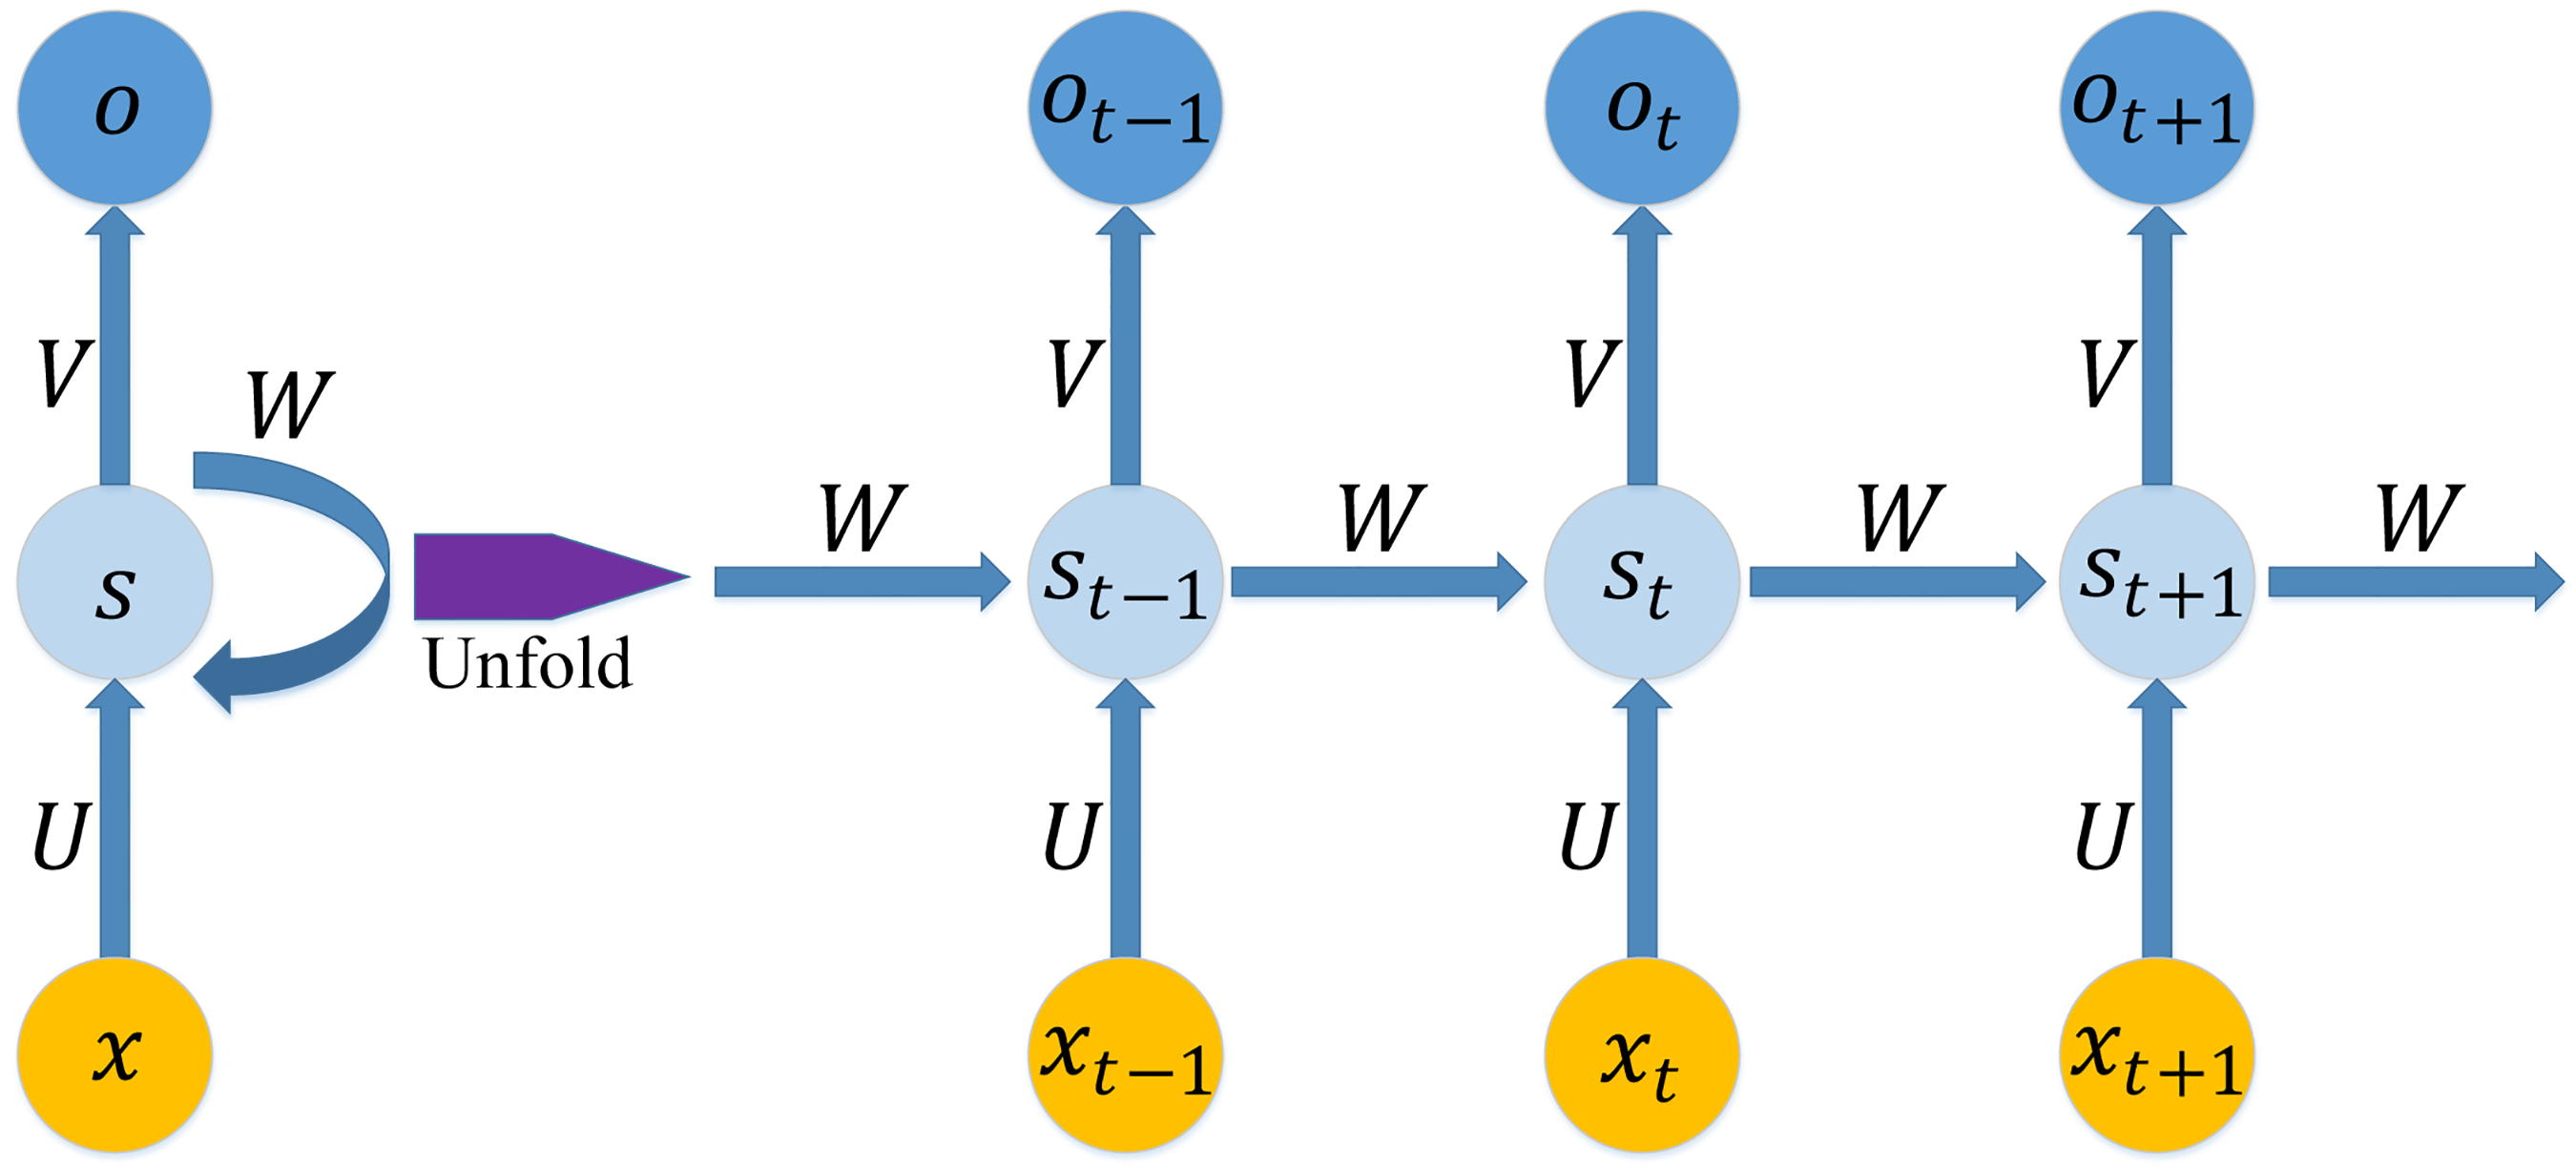

Можно убедиться, что мы получили тот же результат, как если бы подали в нейросеть одну только букву Z:

In [68]:
input = letterToTensor('Z')
hidden = rnn.initHidden()

output, next_hidden = rnn(input.to(device), hidden.to(device))

In [69]:
output

tensor([[-3.0415, -2.9513, -3.0038, -2.8822, -2.8972, -2.7440, -3.0421, -2.8046,
         -2.8428, -2.8496, -2.8631, -2.7036, -2.9315, -2.8846, -2.9917, -2.7070,
         -2.9373, -3.0518]], grad_fn=<LogSoftmaxBackward0>)

Давайте разберемся, что происходит внутри нейросети, на примере одной буквы.

In [71]:
# инициализируем начальное скрытое состояние
hidden_0 = torch.zeros(1, n_hidden)

Во-первых, нам нужно два линейных слоя: один, init_to_hidden, будет принимать закодированную входную букву, второй, hidden_to_hidden, будет принимать скрытое состояние. Во-вторых, нам нужен выходной слой hidden_to_output.

In [75]:
input_size = n_letters
hidden_size = n_hidden
output_size = n_categories

init_to_hidden = nn.Linear(input_size, hidden_size)
hidden_to_hidden = nn.Linear(hidden_size, hidden_size)
hidden_to_output = nn.Linear(hidden_size, output_size)

In [76]:
# сам входной вектор буквы выглядит так
input

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Пропустим входную букву и начальное скрытое состояние через соответствующие слои:

In [77]:
input = init_to_hidden(input)

In [78]:
input.size()

torch.Size([1, 128])

In [81]:
hidden = hidden_to_hidden(hidden_0.to(device))

In [82]:
hidden.size()

torch.Size([1, 128])

Затем нам нужно просуммировать информацию, полученную от текущей буквы (input) и "контекстную" информацию hidden (хотя никакого контекста мы еще, конечно же, не знаем):

In [84]:
sum_i_h = input + hidden

In [85]:
sum_i_h.size()

torch.Size([1, 128])

И применить функцию активации:

In [86]:
activated = F.tanh(input + hidden)

In [87]:
activated.size()

torch.Size([1, 128])

Затем можно получать выходы нейросети и превращать их в вероятности при помощи софтмакса:

In [88]:
output = hidden_to_output(activated)

In [89]:
output.size()

torch.Size([1, 18])

In [90]:
softmax = nn.LogSoftmax(dim=1)

In [91]:
probs = softmax(output)

In [92]:
probs

tensor([[-2.9772, -2.9239, -2.9227, -2.8625, -2.8281, -2.8287, -2.7413, -2.9866,
         -2.7624, -2.8780, -2.9049, -2.9240, -3.0423, -2.9015, -2.7765, -2.9784,
         -2.9885, -2.8604]], grad_fn=<LogSoftmaxBackward0>)

Мы получили немного другой вектор, чем тот, что выше, поскольку инициализировали все слои заново.

Теперь нам нужно еще написать функцию, которая будет превращать выданные вероятности (probs) в лейбл предсказанной категории:

In [93]:
def categoryFromOutput(output):
    # перевод выданных вероятностей в категорию
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(probs))

('Dutch', 6)


In [94]:
output.topk(1)

torch.return_types.topk(
values=tensor([[0.1692]], grad_fn=<TopkBackward0>),
indices=tensor([[6]]))

In [95]:
top_n, top_i = output.topk(1)

In [96]:
print(top_i)
print(top_i[0])
print(top_i[0].item())

tensor([[6]])
tensor([6])
6


Разделение на тестовую и тренировочную выборку:

In [97]:
from sklearn.model_selection import train_test_split

In [98]:
X = []
y = []

for k, v in category_lines.items():
  for w in v:
    X.append(w)
    y.append(k)

In [99]:
len(X) == len(y)

True

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

### Обучение

Объявим наши гиперпараметры: размерность входного слоя (идентична количеству уникальных букв), размерность скрытого слоя (может быть любой), размерность выходного слоя (равна количеству категорий), количество эпох, learning rate и размер батча (могут быть любыми).

In [101]:
input_dim = n_letters
hidden_dim = 128
output_dim = len(all_categories)
num_epochs = 100
learning_rate = 3e-4
batch_size = 1000

Передадим все параметры в модель, выберем функцию потерь и оптимайзер и начнем обучение.

In [116]:
rnn_model = RNN(input_dim, 128, output_dim).to(device)

In [117]:
loss_function = nn.NLLLoss().to(device)
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

In [118]:
losses = []

for epoch in tqdm(range(num_epochs)):
    train_loss = 0

    current_batch = random.sample(range(len(X_train)), batch_size)
    current_X_train = [X_train[i] for i in current_batch]
    current_y_train = [y_train[i] for i in current_batch]

    for current_word, current_category in zip(current_X_train, current_y_train):

      hidden = rnn.initHidden()

      # Очищаем градиент, аккумулированный на предыдущих этапах
      optimizer.zero_grad()

      # кодируем имя и категорию, превращая их в тензоры
      line_tensor = lineToTensor(current_word)
      category_tensor = torch.tensor([all_categories.index(current_category)], dtype=torch.long)

      # forward pass: идем по каждой букве, обновляем веса и получаем вероятности классов для слова
      for i in range(line_tensor.size()[0]):
        output, hidden = rnn_model(line_tensor[i].to(device), hidden.to(device))

      # считаем значение функции потерь и добавляем его к общему лоссу этой эпохи
      loss = loss_function(output, category_tensor.to(device))
      train_loss += loss.item()

      # backward pass: распространяем ошибку обратно, чтобы проапдейтить веса
      loss.backward()

      # Апдейтим веса
      optimizer.step()

    losses.append(train_loss/batch_size)

    print('Epoch {0}, loss {1}'.format(epoch, train_loss/batch_size))

    # перед следующей эпохой зануляем лосс
    train_loss = 0

  1%|          | 1/100 [00:05<09:23,  5.70s/it]

Epoch 0, loss 1.7284661937654018


  2%|▏         | 2/100 [00:08<06:44,  4.13s/it]

Epoch 1, loss 1.6143175542503596


  3%|▎         | 3/100 [00:11<06:00,  3.72s/it]

Epoch 2, loss 1.3965453452337533


  4%|▍         | 4/100 [00:15<06:05,  3.81s/it]

Epoch 3, loss 1.3325807939101941


  5%|▌         | 5/100 [00:19<05:52,  3.71s/it]

Epoch 4, loss 1.1867719611509238


  6%|▌         | 6/100 [00:22<05:28,  3.49s/it]

Epoch 5, loss 1.0789022302055964


  7%|▋         | 7/100 [00:25<05:13,  3.37s/it]

Epoch 6, loss 1.1549545122177223


  8%|▊         | 8/100 [00:29<05:23,  3.51s/it]

Epoch 7, loss 1.0765016914340086


  9%|▉         | 9/100 [00:33<05:25,  3.57s/it]

Epoch 8, loss 1.1476326514551765


 10%|█         | 10/100 [00:36<05:06,  3.41s/it]

Epoch 9, loss 1.1113953320001602


 11%|█         | 11/100 [00:39<04:50,  3.26s/it]

Epoch 10, loss 1.1091200445074356


 12%|█▏        | 12/100 [00:42<04:48,  3.28s/it]

Epoch 11, loss 1.0037334888706682


 13%|█▎        | 13/100 [00:46<05:07,  3.53s/it]

Epoch 12, loss 1.0811051164606469


 14%|█▍        | 14/100 [00:49<04:50,  3.38s/it]

Epoch 13, loss 0.9710415938197985


 15%|█▌        | 15/100 [00:52<04:37,  3.27s/it]

Epoch 14, loss 1.0038488438480708


 16%|█▌        | 16/100 [00:55<04:27,  3.19s/it]

Epoch 15, loss 0.9783745564469136


 17%|█▋        | 17/100 [01:00<04:58,  3.59s/it]

Epoch 16, loss 1.0091747997075873


 18%|█▊        | 18/100 [01:03<04:41,  3.43s/it]

Epoch 17, loss 0.95300479898919


 19%|█▉        | 19/100 [01:06<04:27,  3.30s/it]

Epoch 18, loss 0.9339628127061733


 20%|██        | 20/100 [01:09<04:16,  3.21s/it]

Epoch 19, loss 0.9437123134638968


 21%|██        | 21/100 [01:13<04:33,  3.46s/it]

Epoch 20, loss 0.9390437152484811


 22%|██▏       | 22/100 [01:16<04:29,  3.45s/it]

Epoch 21, loss 0.9554196814756578


 23%|██▎       | 23/100 [01:19<04:14,  3.30s/it]

Epoch 22, loss 0.9164808155712817


 24%|██▍       | 24/100 [01:22<04:05,  3.23s/it]

Epoch 23, loss 0.9530932051286946


 25%|██▌       | 25/100 [01:26<04:10,  3.34s/it]

Epoch 24, loss 0.9610514807451472


 26%|██▌       | 26/100 [01:30<04:19,  3.51s/it]

Epoch 25, loss 0.8428516188310168


 27%|██▋       | 27/100 [01:33<04:06,  3.38s/it]

Epoch 26, loss 0.8779532681259589


 28%|██▊       | 28/100 [01:36<03:55,  3.28s/it]

Epoch 27, loss 0.8038694824636623


 29%|██▉       | 29/100 [01:39<03:55,  3.32s/it]

Epoch 28, loss 0.8969058998859691


 30%|███       | 30/100 [01:43<04:08,  3.55s/it]

Epoch 29, loss 0.8793142170637002


 31%|███       | 31/100 [01:46<03:52,  3.37s/it]

Epoch 30, loss 0.8526600153258769


 32%|███▏      | 32/100 [01:49<03:41,  3.26s/it]

Epoch 31, loss 0.8449256363433597


 33%|███▎      | 33/100 [01:52<03:34,  3.20s/it]

Epoch 32, loss 0.8760720817039255


 34%|███▍      | 34/100 [01:57<03:58,  3.62s/it]

Epoch 33, loss 0.8382439490753822


 35%|███▌      | 35/100 [02:00<03:43,  3.44s/it]

Epoch 34, loss 0.8249199005031623


 36%|███▌      | 36/100 [02:03<03:33,  3.34s/it]

Epoch 35, loss 0.7335197517488851


 37%|███▋      | 37/100 [02:06<03:25,  3.26s/it]

Epoch 36, loss 0.7553900783445279


 38%|███▊      | 38/100 [02:10<03:39,  3.54s/it]

Epoch 37, loss 0.8430485322772947


 39%|███▉      | 39/100 [02:13<03:28,  3.41s/it]

Epoch 38, loss 0.8612309356584664


 40%|████      | 40/100 [02:16<03:16,  3.28s/it]

Epoch 39, loss 0.8100208616003293


 41%|████      | 41/100 [02:19<03:09,  3.21s/it]

Epoch 40, loss 0.7618367881880694


 42%|████▏     | 42/100 [02:23<03:16,  3.40s/it]

Epoch 41, loss 0.7962433878632291


 43%|████▎     | 43/100 [02:27<03:18,  3.48s/it]

Epoch 42, loss 0.7891071293252316


 44%|████▍     | 44/100 [02:30<03:06,  3.34s/it]

Epoch 43, loss 0.7670840881482436


 45%|████▌     | 45/100 [02:33<02:59,  3.26s/it]

Epoch 44, loss 0.8526951273352679


 46%|████▌     | 46/100 [02:37<02:59,  3.33s/it]

Epoch 45, loss 0.7927589905235218


 47%|████▋     | 47/100 [02:41<03:07,  3.54s/it]

Epoch 46, loss 0.7866343986358406


 48%|████▊     | 48/100 [02:44<02:56,  3.40s/it]

Epoch 47, loss 0.8029946112891339


 49%|████▉     | 49/100 [02:47<02:47,  3.29s/it]

Epoch 48, loss 0.7544061655396399


 50%|█████     | 50/100 [02:50<02:43,  3.28s/it]

Epoch 49, loss 0.7463719704903596


 51%|█████     | 51/100 [02:54<02:56,  3.59s/it]

Epoch 50, loss 0.7293388000805571


 52%|█████▏    | 52/100 [02:57<02:44,  3.43s/it]

Epoch 51, loss 0.7743287147363153


 53%|█████▎    | 53/100 [03:00<02:34,  3.28s/it]

Epoch 52, loss 0.7565062577197786


 54%|█████▍    | 54/100 [03:05<02:51,  3.73s/it]

Epoch 53, loss 0.7733379639658088


 55%|█████▌    | 55/100 [03:09<02:54,  3.89s/it]

Epoch 54, loss 0.7969230103350273


 56%|█████▌    | 56/100 [03:12<02:39,  3.63s/it]

Epoch 55, loss 0.7534288513653664


 57%|█████▋    | 57/100 [03:15<02:28,  3.45s/it]

Epoch 56, loss 0.7834256270980877


 58%|█████▊    | 58/100 [03:18<02:20,  3.33s/it]

Epoch 57, loss 0.7398472276647008


 59%|█████▉    | 59/100 [03:23<02:29,  3.64s/it]

Epoch 58, loss 0.7324994632650415


 60%|██████    | 60/100 [03:26<02:18,  3.46s/it]

Epoch 59, loss 0.7427242466479074


 61%|██████    | 61/100 [03:29<02:09,  3.33s/it]

Epoch 60, loss 0.7087151153368577


 62%|██████▏   | 62/100 [03:32<02:04,  3.27s/it]

Epoch 61, loss 0.7326296851885418


 63%|██████▎   | 63/100 [03:36<02:10,  3.52s/it]

Epoch 62, loss 0.7245879564709612


 64%|██████▍   | 64/100 [03:39<02:04,  3.47s/it]

Epoch 63, loss 0.6953061251006165


 65%|██████▌   | 65/100 [03:42<01:56,  3.33s/it]

Epoch 64, loss 0.6902495596534555


 66%|██████▌   | 66/100 [03:45<01:49,  3.23s/it]

Epoch 65, loss 0.7398991655283935


 67%|██████▋   | 67/100 [03:49<01:49,  3.31s/it]

Epoch 66, loss 0.7118368233169403


 68%|██████▊   | 68/100 [03:53<01:50,  3.45s/it]

Epoch 67, loss 0.6481068615510485


 69%|██████▉   | 69/100 [03:56<01:42,  3.31s/it]

Epoch 68, loss 0.6618421665489331


 70%|███████   | 70/100 [03:59<01:36,  3.23s/it]

Epoch 69, loss 0.7080737637060792


 71%|███████   | 71/100 [04:02<01:34,  3.24s/it]

Epoch 70, loss 0.6913011562346146


 72%|███████▏  | 72/100 [04:06<01:39,  3.54s/it]

Epoch 71, loss 0.6454922965265251


 73%|███████▎  | 73/100 [04:09<01:31,  3.38s/it]

Epoch 72, loss 0.6940145541512593


 74%|███████▍  | 74/100 [04:12<01:25,  3.27s/it]

Epoch 73, loss 0.6494982339945582


 75%|███████▌  | 75/100 [04:15<01:20,  3.20s/it]

Epoch 74, loss 0.761569869314516


 76%|███████▌  | 76/100 [04:20<01:26,  3.59s/it]

Epoch 75, loss 0.7122317880054234


 77%|███████▋  | 77/100 [04:23<01:19,  3.44s/it]

Epoch 76, loss 0.6998927985357405


 78%|███████▊  | 78/100 [04:26<01:12,  3.31s/it]

Epoch 77, loss 0.6741909817712867


 79%|███████▉  | 79/100 [04:29<01:08,  3.24s/it]

Epoch 78, loss 0.6506866620649271


 80%|████████  | 80/100 [04:33<01:10,  3.55s/it]

Epoch 79, loss 0.6943193609164782


 81%|████████  | 81/100 [04:37<01:06,  3.52s/it]

Epoch 80, loss 0.6655333922118907


 82%|████████▏ | 82/100 [04:40<01:00,  3.36s/it]

Epoch 81, loss 0.642752781165329


 83%|████████▎ | 83/100 [04:43<00:55,  3.26s/it]

Epoch 82, loss 0.6841683942032368


 84%|████████▍ | 84/100 [04:46<00:55,  3.44s/it]

Epoch 83, loss 0.6692105414259877


 85%|████████▌ | 85/100 [04:50<00:52,  3.51s/it]

Epoch 84, loss 0.6291532022127049


 86%|████████▌ | 86/100 [04:53<00:47,  3.37s/it]

Epoch 85, loss 0.659831245035255


 87%|████████▋ | 87/100 [04:56<00:42,  3.27s/it]

Epoch 86, loss 0.6793476941028394


 88%|████████▊ | 88/100 [05:00<00:40,  3.38s/it]

Epoch 87, loss 0.6110370168401469


 89%|████████▉ | 89/100 [05:04<00:39,  3.55s/it]

Epoch 88, loss 0.6322224846296794


 90%|█████████ | 90/100 [05:07<00:34,  3.40s/it]

Epoch 89, loss 0.6334970486208095


 91%|█████████ | 91/100 [05:10<00:29,  3.28s/it]

Epoch 90, loss 0.640742833562731


 92%|█████████▏| 92/100 [05:13<00:26,  3.26s/it]

Epoch 91, loss 0.5823678629288297


 93%|█████████▎| 93/100 [05:17<00:25,  3.58s/it]

Epoch 92, loss 0.6396773946937329


 94%|█████████▍| 94/100 [05:20<00:20,  3.40s/it]

Epoch 93, loss 0.6485779753965472


 95%|█████████▌| 95/100 [05:23<00:16,  3.27s/it]

Epoch 94, loss 0.6128697914729583


 96%|█████████▌| 96/100 [05:26<00:12,  3.19s/it]

Epoch 95, loss 0.5735780601368433


 97%|█████████▋| 97/100 [05:31<00:10,  3.48s/it]

Epoch 96, loss 0.6557352272728203


 98%|█████████▊| 98/100 [05:34<00:06,  3.42s/it]

Epoch 97, loss 0.624963367581624


 99%|█████████▉| 99/100 [05:37<00:03,  3.30s/it]

Epoch 98, loss 0.5845651791364671


100%|██████████| 100/100 [05:40<00:00,  3.40s/it]

Epoch 99, loss 0.6514622633356448


Оценим качество тренировки и предсказаний: посмотрим на график лосса и classification_report.

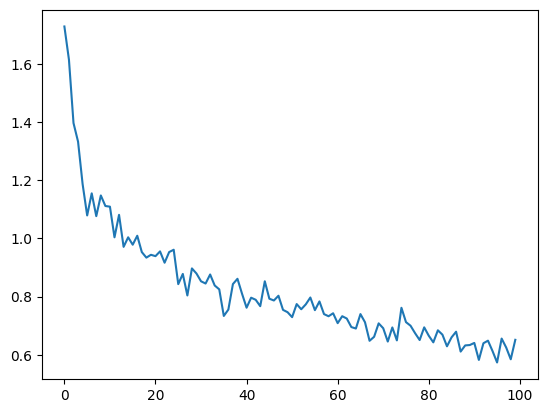

In [119]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [120]:
from sklearn.metrics import classification_report

rnn_predictions = []
original_lables = []

# этот метод означает, что нам не нужно считать градиент для обратного распространения ошибки, а нужно сделать только предсказания
with torch.no_grad():
  for word, cat in zip(X_test, y_test):
    line_tensor = lineToTensor(word)

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_model(line_tensor[i], hidden)

    current_cat, cat_label = categoryFromOutput(output)
    rnn_predictions.append(cat_label)
    original_lables.append(all_categories.index(cat))

In [121]:
print(classification_report(original_lables, rnn_predictions, target_names=all_categories))

              precision    recall  f1-score   support

     Chinese       0.44      0.18      0.26        67
      Arabic       0.79      0.10      0.17       500
       Czech       0.14      0.26      0.18       130
      German       0.25      0.18      0.21       181
      Korean       0.05      0.04      0.04        24
    Japanese       0.52      0.30      0.38       248
       Dutch       0.10      0.15      0.12        74
      Polish       0.09      0.23      0.12        35
      French       0.50      0.01      0.03        69
       Greek       0.34      0.43      0.38        51
  Portuguese       0.00      0.00      0.00        18
    Scottish       0.00      0.00      0.00        25
       Irish       0.11      0.14      0.12        58
     Spanish       0.18      0.12      0.15        75
     English       0.49      0.21      0.29       917
     Italian       0.48      0.29      0.36       177
  Vietnamese       0.00      0.00      0.00        18
     Russian       0.59    

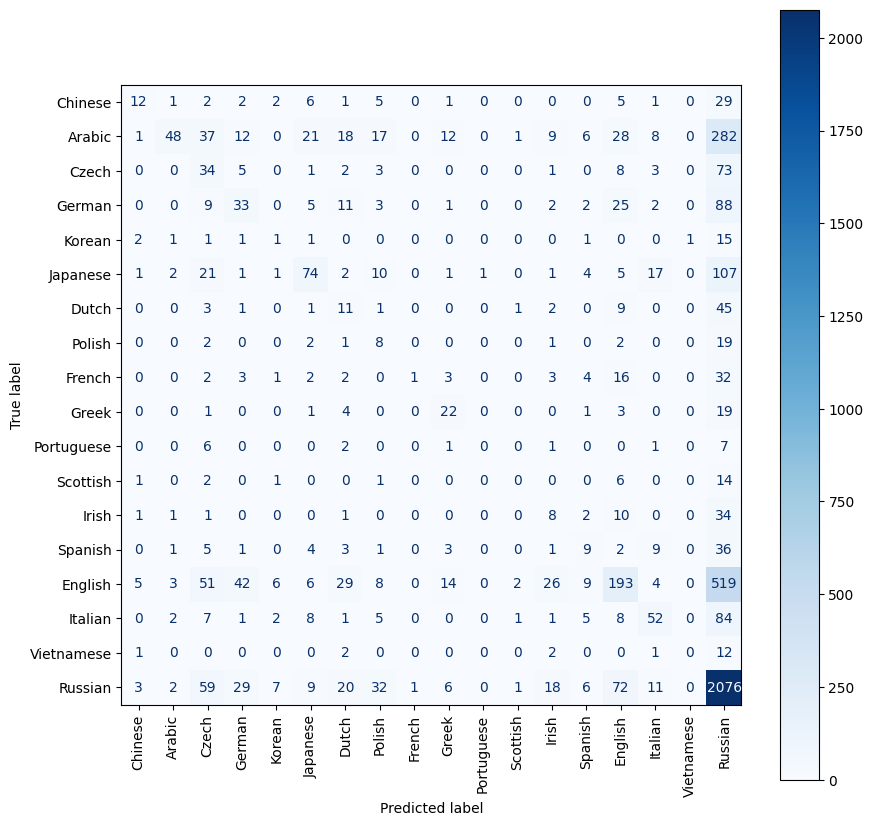

In [122]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(original_lables,
                                        rnn_predictions,
                                        display_labels=all_categories,
                                        ax=ax,
                                        xticks_rotation='vertical', cmap='Blues')